In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [2]:
pasta = '../datasets/'
dataset = 'arrecadacao_Brasil_ajustada.csv'

tipo_dados = {'arrecadacao': np.float64}

# Carrega o dataframe com a arrecadação ajustada
df = pd.read_csv(pasta + dataset, dtype=tipo_dados, parse_dates=True, index_col='data')

### Tentativa de determinar os parâmetros p e q através dos plots ACF e PACF

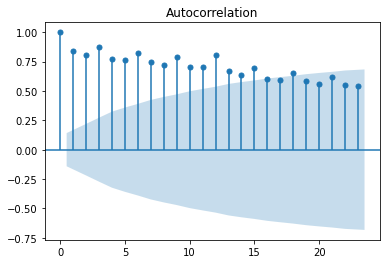

In [3]:
# Verificar sobre a série original

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['arrecadacao'].dropna());

In [4]:
# O Plot ACF acima indica que a série é não estacionária
# Calculando a diferença de 1 período
df['arrecadacao_d1']=df['arrecadacao'].diff()

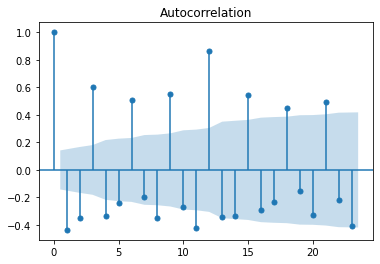

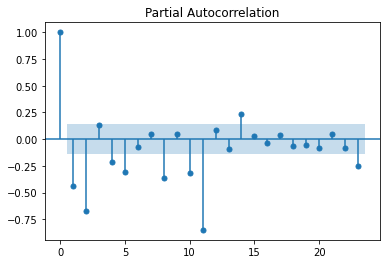

In [5]:
# ACF e PACF sobre a série com diferenciação de 1 período
plot_acf(df['arrecadacao_d1'].dropna())
plot_pacf(df['arrecadacao_d1'].dropna());

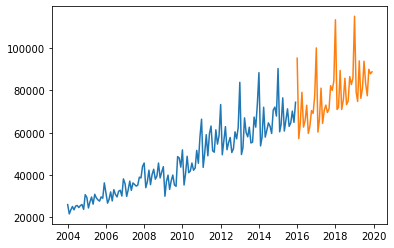

In [6]:
# Vamos realizar a previsão dos últimos 04 anos (2016 a 2019) e comparar com o efetivamente arrecadado
df_efetiva = df[['arrecadacao']].copy()

# Vamos criar o train e test split
train = df_efetiva['2004-01-01':'2015-12-01']
test = df_efetiva['2016-01-01':'2019-12-01']

plt.plot(train)
plt.plot(test);

In [7]:
from statsmodels.tsa.arima.model import ARIMA
# Atribuição inicial p=3, d=1 e q=3
arima=ARIMA(train, order=(3,1,3))

D:\Anaconda\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Anaconda\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Sobre o waring acima, podemos verificar nesse link todos os tipos que "freq" pode assumir:
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

Como as datas utilizadas no índice são do tipo 01-MM-AAAA, utilizaremos MS - Month start Frequency


In [8]:
train.index.freq = 'MS'
test.index.freq = 'MS'

# Rodar novamente, agora não apresentou warning
arima=ARIMA(train, order=(3,1,3))

In [9]:
# FIT
model=arima.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            arrecadacao   No. Observations:                  144
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1431.743
Date:                Sat, 01 May 2021   AIC                           2877.487
Time:                        16:05:36   BIC                           2898.227
Sample:                    01-01-2004   HQIC                          2885.915
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7178      0.251     -2.860      0.004      -1.210      -0.226
ar.L2         -0.7188      0.243     -2.963      0.003      -1.194      -0.243
ar.L3          0.2673      0.229      1.165      0.244      -0.182       0.717
ma.L1          0.1728      0.233      0.742      0.458      -0.283       0.629
ma.L2          0.1788      0.152      1.173      0.241      -0.120       0.478
ma.L3         -0.6877      0.142     -4.840      0.000      -0.966      -0.409
sigma2      3.399e+07   1.11e-08   3.07e+15      0.000     3.4e+07     3.4e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                23.53
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               4.29   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.23e+31. Standard errors may be unstable.
"""

In [10]:
# Gera as previsões na mesma quantidade de pontos que o "test"
predictions_1 = pd.DataFrame(model.forecast(steps=len(test)))

In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Calcula o erro RMSE
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions_1)):.2f}')

# Cálculo do coeficiente de determinação, também chamado de R²
print(f'R2: {r2_score(test, predictions_1):.2f}')
               
# Mean absolute percentage error (MAPE) - a measure of prediction accuracy of a forecasting method in statistics
print(f'MAPE: {100*mean_absolute_percentage_error(test, predictions_1):.2f}')

RMSE: 13432.51
R2: -0.16
MAPE: 12.25


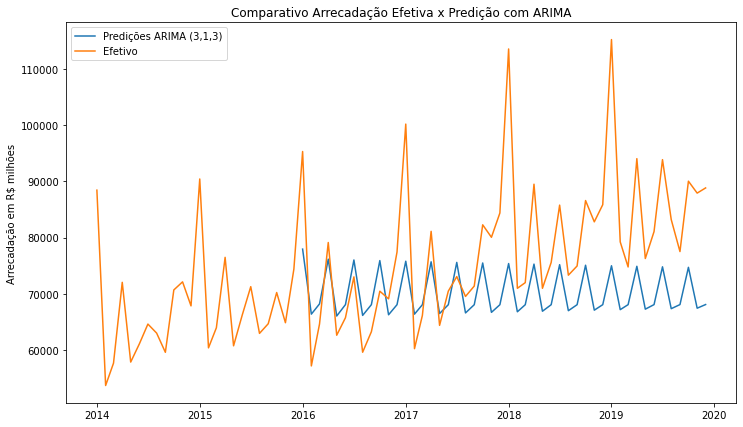

In [12]:
plt.figure(figsize = (12,7))
plt.title('Comparativo Arrecadação Efetiva x Predição com ARIMA')
plt.plot(predictions_1, label = "Predições ARIMA (3,1,3)")
plt.plot(df_efetiva[-72:], label = "Efetivo")
plt.legend(loc = 'upper left')
plt.ylabel('Arrecadação em R$ milhões')
plt.show()

### Modelo se apresentou com elevados erros e o comportamento gráfico deixa claro que não conseguiu se ajustar aos dados.

In [13]:
# Tentativa de encontrar os melhores hiperparâmetros para o modelo ARIMA
p_values=range(0,6)
q_values=range(0,6)
d_values=range(1,3)

warnings.filterwarnings('ignore')

# Dicionário para armazenar os erros de cada conjunto de parâmetros (p,d,q)
d_erros={}
d_aic={}

for p in p_values:
    for d in d_values:
        for q in q_values:
            order=(p,d,q)
            predictions=[]
            #Alguns modelos podem falhar devido aos hiperparâmetros utilizados
            try: 
                arima = ARIMA(train, order=order)
                model = arima.fit()
                predictions = pd.DataFrame(model.forecast(steps=len(test)))
                error = np.sqrt(mean_squared_error(test, predictions))
                #print(f'RMSE is {error:.2f} with order {order}')
                d_erros[order] = error
                d_aic[order] = model.aic
            except:
                print(f"Erro na execução da combinação {order}\n")
                

In [14]:
# Identificar qual a chave do dicionário com o menor erro
melhor_order = min(d_erros, key=d_erros.get)
melhor_aic = min(d_aic, key=d_aic.get)

erro = d_erros[melhor_order]
print(f'Combinação (p,d,q)={melhor_order} que apresentou menor erro, RMSE={erro:.2f}.')

Combinação (p,d,q)=(3, 2, 5) que apresentou menor erro, RMSE=8638.98.


In [15]:
print(f'{d_aic[melhor_aic]:.2f}', f'{d_aic[(3, 2, 5)]:.2f}')

2866.85 2871.35


In [16]:
# Vamos então aplicar a melhor combinação (p,d,q) ao modelo
#melhor_order=(3, 2, 5)

arima=ARIMA(train, order=melhor_order)
model2=arima.fit()
model2.summary()
predictions_2 = pd.DataFrame(model2.forecast(steps=len(test)))

In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Calcula o erro RMSE
print(f'RMSE: {np.sqrt(mean_squared_error(test, predictions_2)):.2f}')

# Cálculo do coeficiente de determinação, também chamado de R²
print(f'R2: {r2_score(test, predictions_2):.2f}')
               
# Mean absolute percentage error (MAPE) - a measure of prediction accuracy of a forecasting method in statistics
print(f'MAPE: {100*mean_absolute_percentage_error(test, predictions_2):.2f}%')

RMSE: 8638.98
R2: 0.52
MAPE: 8.32%


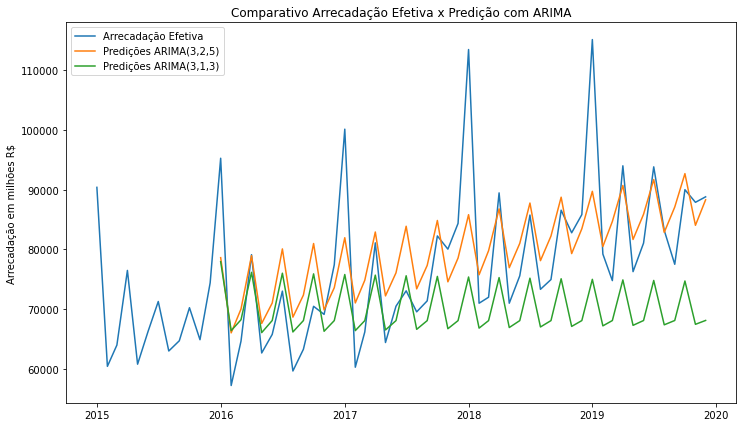

In [18]:
plt.figure(figsize = (12,7))
plt.title('Comparativo Arrecadação Efetiva x Predição com ARIMA')
plt.plot(df_efetiva[-60:], label = "Arrecadação Efetiva")
plt.plot(predictions_2, label = "Predições ARIMA(3,2,5)")
plt.plot(predictions_1, label = "Predições ARIMA(3,1,3)")
plt.legend(loc = 'upper left')
plt.ylabel('Arrecadação em milhões R$')
plt.show()

* Nota-se que a previsão do modelo ARIMA(3,2,5) se aproximou mais da linha da arrecadação efetiva, no entanto não foi capaz de se ajustar ao comportamento da série temporal.
* De forma resumida, o modelo **carece da componente sazonal** para poder representar a série corretamente.
